# Data Preparation Step

* Import the needed libraries

In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [47]:
class HeartDiseaseData:
    def __init__(self, data_path):
        self.data_path = data_path
        self.df = None
        self.X = None
        self.y = None
        self.X_train = None
        self.X_val = None
        self.X_test = None
        self.y_train = None
        self.y_val = None
        self.y_test = None
        self.df_encoded = None
        self.df_standardized = None

    def load_data(self):
        # Load dataset from a CSV file
        self.df = pd.read_csv(self.data_path)
        print(self.df.head())

    def split_features_target(self, target_column):
        # Split the dataset into features (X) and target (y)
        self.X = self.df.drop(columns=[target_column])
        self.y = self.df[target_column]

    def encode_categorical_columns(self, categorical_columns):
        # Perform one-hot encoding for categorical columns
        self.df_encoded = pd.get_dummies(self.X, columns=categorical_columns, dtype='uint8')
        print("Encoded Columns:", self.df_encoded.columns)

    def split_train_validation_test(self, train_size=0.7, test_size=0.2, val_size=0.1, random_state=42):
        # Split dataset into training, validation, and test sets while maintaining class distribution
        self.X_train, X_temp, self.y_train, y_temp = train_test_split(
            self.df_encoded, self.y, test_size=(1 - train_size), stratify=self.y, random_state=random_state
        )
        self.X_val, self.X_test, self.y_val, self.y_test = train_test_split(
            X_temp, y_temp, test_size=(test_size / (test_size + val_size)), stratify=y_temp, random_state=random_state
        )

    def print_class_distribution(self):
        # Split dataset into training, validation, and test sets while maintaining class distribution
        print("Training Class Distribution:\n", self.y_train.value_counts(normalize=True))
        print("Validation Class Distribution:\n", self.y_val.value_counts(normalize=True))
        print("Test Class Distribution:\n", self.y_test.value_counts(normalize=True))

    def standardize_features(self, dataset):
        # Standardize numerical features using StandardScaler
        scaler = StandardScaler()
        self.df_standardized = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns)
        print(self.df_standardized.head())
        return self.df_standardized

    def preprocess_data(self, target_column, categorical_columns):
        # Run preprocessing steps
        self.load_data()
        self.split_features_target(target_column)
        self.encode_categorical_columns(categorical_columns)
        self.split_train_validation_test()
        self.print_class_distribution()
        self.standardize_features(self.df_encoded)

In [48]:
data_path = "heart.csv"
target_column = 'HeartDisease'
categorical_columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

# Initialize the data processor
data_processor = HeartDiseaseData(data_path)

# Preprocess the data
data_processor.preprocess_data(target_column, categorical_columns)

# Data
X_train = data_processor.X_train
X_val = data_processor.X_val
X_test = data_processor.X_test
y_train = data_processor.y_train
y_val = data_processor.y_val
y_test = data_processor.y_test
df_standardized = data_processor.df_standardized

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  
Encoded Columns: Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak',
       'Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA',
       'ChestPainType_NAP', 'ChestPainType_TA', 

# Evaluation

In [49]:
class ModelEvaluator:
    def __init__(self,model,model_name,color_theme='Blues'):
        self.model = model
        self.model_name = model_name
        self.color_theme = color_theme
        self.y_pred = None
        self.accuracy = None
        self.f1_score = None
        self.conf_matrix = None

    def evaluate(self,X_test,y_test):
        # Evaluate the model on the test set
        self.y_pred = self.model.predict(X_test)
        # handle both probabilities and class labels
        if self.y_pred.ndim == 1: # class labels
            pass
        else: # probabilities
            self.y_pred = (self.y_pred>0.5).astype(int) 
            
        self.accuracy = accuracy_score(y_test,self.y_pred)
        self.f1_score = f1_score(y_test,self.y_pred)
        self.conf_matrix = confusion_matrix(y_test,self.y_pred)
        return self.accuracy,self.f1_score,self.conf_matrix
    
    def evaluate_bagging(self, X_test, y_test):
        y_m_model = []
        y_bagging = []

        for i in range(0, len(self.model)):
            y_m_model.append(self.model[i].predict(X_test))
        
        y_maj_vote = [sum(col) / len(col) for col in zip(*y_m_model)]
        for i in range(0, len(y_maj_vote)):
            if(y_maj_vote[i] > 0.5): y_bagging.append(1)
            else: y_bagging.append(0)
        self.y_pred = y_bagging
        self.accuracy = accuracy_score(y_test, self.y_pred)
        self.f1_score = f1_score(y_test, self.y_pred)
        self.conf_matrix = confusion_matrix(y_test, self.y_pred)
        return self.accuracy,self.f1_score,self.conf_matrix
    
    def plot_confusion_matrix(self,font_size=14,title_font_size=16,annot_font_size=12):
        # Plot the confusion matrix
        plt.figure(figsize=(5,5))
        sns.heatmap(            
            self.conf_matrix,
            annot=True,
            fmt='d',
            cmap=self.color_theme,
            xticklabels=['No heart disease','Heart disease'],
            yticklabels=['No heart disease','Heart disease'],
            annot_kws={"size":annot_font_size,"weight":"bold"},
            cbar_kws={"shrink":0.8}
            )
        plt.xlabel('Predicted',fontsize=font_size,weight='bold')
        plt.ylabel('True',fontsize=font_size,weight='bold')
        plt.title(f'Confusion matrix for {self.model_name}',fontsize=title_font_size,weight='bold',pad=20)
        plt.xticks(fontsize=font_size)
        plt.yticks(fontsize=font_size)
        plt.show()

    def print_metrics(self):
        # Print evaluation metrics
        print("Model",self.model_name)
        print("Accuracy",self.accuracy)
        print("F1-score:",self.f1_score)
        print("\nClassification report:")
        print(classification_report(y_test,self.y_pred,target_names=['No heart disease','Heart disease']))

    def find_most_confusing_classes(self):
        confusion_matrix2 = self.conf_matrix.copy()
        np.fill_diagonal(confusion_matrix2,0) # because correct predictions are on the diagonal
        most_confusing = np.unravel_index(np.argmax(confusion_matrix2),confusion_matrix2.shape)
        print(f"Most confusing classes: True label {most_confusing[0]} --> predicted as {most_confusing[1]}")

    def summarize(self,X_test,y_test):
        # Runs all evaluation steps and summarize the results
        self.evaluate(X_test,y_test)
        self.print_metrics()
        self.plot_confusion_matrix()
        self.find_most_confusing_classes()

    def summarize_bagging(self,X_test,y_test):
        # Runs all evaluation steps and summarize the results
        self.evaluate_bagging(X_test,y_test)
        self.print_metrics()
        self.plot_confusion_matrix()
        self.find_most_confusing_classes()

# KNN Classifier

In [50]:
class KNN_Classifier:
    def train_knn_model(self, n_neighbors):
        knn = KNeighborsClassifier(n_neighbors)
        knn.fit(data_processor.standardize_features(X_train), y_train)
        return knn
    
    def validate_knn_model(self, knn):
        y_pred = knn.predict(data_processor.standardize_features(X_val))
        accuracy = accuracy_score(y_val,y_pred)
        return accuracy

        Age  RestingBP  Cholesterol  FastingBS     MaxHR   Oldpeak     Sex_F  \
0  0.856064  -0.672618    -1.882352   1.868023 -0.082372 -1.563271 -0.520852   
1  0.331343   0.435467    -1.882352  -0.535325 -0.629164  1.037503 -0.520852   
2  0.331343   0.989510     0.489677  -0.535325 -1.722749  1.966351 -0.520852   
3  1.905508   1.543553    -1.882352  -0.535325 -0.863504  0.665964 -0.520852   
4  0.226399   2.097596    -1.882352  -0.535325 -0.511994  1.501927 -0.520852   

      Sex_M  ChestPainType_ASY  ChestPainType_ATA  ChestPainType_NAP  \
0  0.520852          -1.108678          -0.467136          -0.520852   
1  0.520852           0.901975          -0.467136          -0.520852   
2  0.520852           0.901975          -0.467136          -0.520852   
3  0.520852          -1.108678          -0.467136           1.919930   
4  0.520852          -1.108678          -0.467136           1.919930   

   ChestPainType_TA  RestingECG_LVH  RestingECG_Normal  RestingECG_ST  \
0          4.

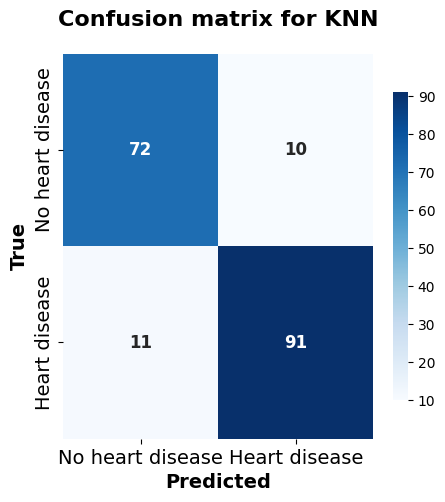

Most confusing classes: True label 1 --> predicted as 0


In [51]:
best_k = 1
best_accuracy = 0
knn_classifier = KNN_Classifier()
for k in range(1, 31):
    knn = knn_classifier.train_knn_model(k)
    accuracy = knn_classifier.validate_knn_model(knn)
    if(accuracy > best_accuracy):
        best_accuracy = accuracy
        best_k = k

print(f"Best_K_According_to_Validation: {best_k}")
print(f"Best_Accuracy: {best_accuracy}\n")
    
best_knn = knn_classifier.train_knn_model(best_k)
knn_eval = ModelEvaluator(best_knn,"KNN")
knn_eval.summarize(data_processor.standardize_features(X_test), y_test)


# Decision Tree

In [52]:
class DecisionTreeClassifier:
    class Node:
        def __init__(
            self,
            feature : int  | None = None,
            threshold: float | None = None,
            predicted_class: int | None  = None,
            depth: int | None = None,
            left: "Node | None" = None,
            right: "Node | None" = None,
        ):
            self.feature = feature
            self.threshold = threshold  # <= threshold goes to left, > threshold goes to right
            self.left = left
            self.right = right
            self.predicted_class = predicted_class
            self.depth = depth

    def __init__(self, max_depth: int = 4, min_samples_split: int =10):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def fit(self, X : pd.DataFrame, y : pd.Series):
        self.root = self._build_decision_tree(X, y, 0)

    def predict(self, X : pd.DataFrame) -> list[int]: # classification of each input
        predictions_list = [ self._traverse_tree(row, self.root) for _, row in X.iterrows() ]
        return predictions_list

    def _build_decision_tree(self, X : pd.DataFrame, y : pd.Series, curr_depth : int) -> Node:
        if (curr_depth == self.max_depth or len(set(y)) == 1 or self.min_samples_split > len(y)):
            return self.Node(predicted_class=Counter(y).most_common(1)[0][0], depth=curr_depth)

        feature, threshold = self._best_split(X, y)
        tree_node = self.Node(feature= feature,threshold=threshold,depth=curr_depth)

        X_left_split = X.loc[X.iloc[:, feature] <= threshold, :]
        y_left_split = y[X.iloc[:, feature] <= threshold]
        X_right_split = X.loc[X.iloc[:, feature] > threshold, :]
        y_right_split = y[X.iloc[:, feature] > threshold]

        tree_node.left = self._build_decision_tree(X_left_split, y_left_split, curr_depth + 1)
        tree_node.right = self._build_decision_tree(X_right_split, y_right_split, curr_depth + 1)
        return tree_node

    def _best_split(self, X : pd.DataFrame, y : pd.Series) -> tuple: # feature and thresold are integers
        unique_values_list = [np.unique(X.iloc[:, i].values) for i in range(X.shape[1])]
        mid_points_list = [values[:-1] + np.diff(values) / 2 for values in unique_values_list]

        max_info_gain = {"infoGain": -float("inf"), "feature": -1, "threshold": None}
        for i in range(X.shape[1]):
            local_max_info_gain = { "infoGain": -float("inf"), "feature": -1, "threshold": None}
            for split in mid_points_list[i]:
                left_split = y[X.iloc[:, i] <= split]
                right_split = y[X.iloc[:, i] > split]
                info_gain = self._information_gain(y, left_split, right_split)
                if info_gain > local_max_info_gain["infoGain"]:
                    local_max_info_gain = { "infoGain": info_gain, "feature": i, "threshold": split}
            if local_max_info_gain["infoGain"] > max_info_gain["infoGain"]:
                max_info_gain = local_max_info_gain

        return max_info_gain["feature"], max_info_gain["threshold"]

    def _traverse_tree(self, x : pd.Series, node : Node) -> int: # returns a class
        if node.predicted_class is not None:
            return node.predicted_class
        return self._traverse_tree(x, node.left) if x[node.feature] <= node.threshold else self._traverse_tree(x, node.right)

    def _information_gain(self, y : pd.Series, y1 : pd.Series, y2 : pd.Series) -> float:
        y_entropy = self._entropy(y)
        y_entropy_after_split_1 = self._entropy(y1)
        y_entropy_after_split_2 = self._entropy(y2)
        return (
            y_entropy
            - (len(y1) / len(y)) * y_entropy_after_split_1
            - (len(y2) / len(y)) * y_entropy_after_split_2
        )

    def _entropy(self, y : pd.Series) -> float | int:
        zeroes_number = (y == 0).sum()
        ones_number = (y == 1).sum()
        probs = np.array([ones_number / len(y), zeroes_number / len(y)])
        return -np.sum(probs * np.log2(np.where(probs == 0, 1, probs)))


cls = DecisionTreeClassifier()
cls.fit(X_train, y_train)
predict_list = cls.predict(X_train)

correct = 0
for i in range(len(predict_list)):
    if predict_list[i] == y_train.iloc[i]:
        correct += 1

print(f"Train => correct : {correct}, training set accuracy: {correct / len(y_train)}")

predict_list = cls.predict(X_val)

correct = 0
for i in range(len(predict_list)):
    if predict_list[i] == y_val.iloc[i]:
        correct += 1

print(
    f"Validation => correct : {correct}, training set accuracy: {correct / len(y_val)}"
)

predict_list = cls.predict(X_test)

correct = 0
for i in range(len(predict_list)):
    if predict_list[i] == y_test.iloc[i]:
        correct += 1

print(f"Test => correct : {correct}, training set accuracy: {correct / len(y_test)}")

Train => correct : 549, training set accuracy: 0.8551401869158879
Validation => correct : 80, training set accuracy: 0.8695652173913043
Test => correct : 155, training set accuracy: 0.842391304347826


C:\Users\Hager\AppData\Local\Temp\ipykernel_18428\1479219446.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return self._traverse_tree(x, node.left) if x[node.feature] <= node.threshold else self._traverse_tree(x, node.right)


# Bagging

In [53]:
class Bagging_Classifier:
    def train_single_model(self, m):
            X_resampled, y_resampled = resample(X_train, y_train, replace=True, random_state=m)
            decision_tree_model = DecisionTreeClassifier()
            decision_tree_model.fit(X_resampled, y_resampled)
            return decision_tree_model

    def validate_bagging_model(self, m_models):
        y_m_model = []
        y_bagging = []

        for i in range(0, len(m_models)):
            y_m_model.append(m_models[i].predict(X_val))
        
        y_maj_vote = [sum(col) / len(col) for col in zip(*y_m_model)]
        for i in range(0, len(y_maj_vote)):
            if(y_maj_vote[i] > 0.5): y_bagging.append(1)
            else: y_bagging.append(0)

        accuracy = accuracy_score(y_val,y_bagging)
        return accuracy


C:\Users\Hager\AppData\Local\Temp\ipykernel_18428\1479219446.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return self._traverse_tree(x, node.left) if x[node.feature] <= node.threshold else self._traverse_tree(x, node.right)
C:\Users\Hager\AppData\Local\Temp\ipykernel_18428\1479219446.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return self._traverse_tree(x, node.left) if x[node.feature] <= node.threshold else self._traverse_tree(x, node.right)
C:\Users\Hager\AppData\Local\Temp\ipykernel_18428\1479219446.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future vers

Best_M_According_to_Validation: 6
Best_Accuracy: 0.8913043478260869

Model Bagging
Accuracy 0.8695652173913043
F1-score: 0.8811881188118812

Classification report:
                  precision    recall  f1-score   support

No heart disease       0.85      0.87      0.86        82
   Heart disease       0.89      0.87      0.88       102

        accuracy                           0.87       184
       macro avg       0.87      0.87      0.87       184
    weighted avg       0.87      0.87      0.87       184



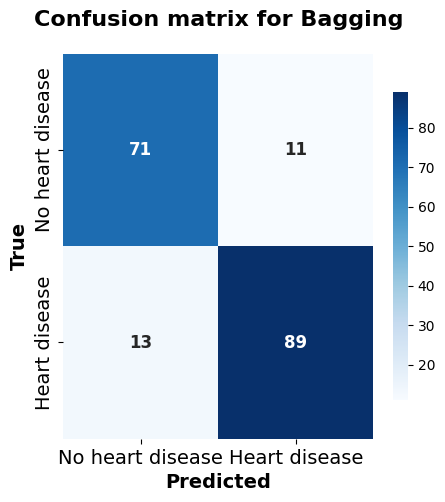

Most confusing classes: True label 1 --> predicted as 0


In [54]:
best_m = 1
best_accuracy = 0
best_models = []
Bagging_classifier = Bagging_Classifier()
m_models = []
for m in range(1, 31):
    m_models.append(Bagging_classifier.train_single_model(m))
    accuracy = Bagging_classifier.validate_bagging_model(m_models)
    if(accuracy > best_accuracy):
        best_accuracy = accuracy
        best_m = m
        best_models = m_models

print(f"Best_M_According_to_Validation: {best_m}")
print(f"Best_Accuracy: {best_accuracy}\n")
    
bagging_eval = ModelEvaluator(best_models,"Bagging")
bagging_eval.summarize_bagging(X_test, y_test)
